# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import os
import pandas as pd

# Options

In [2]:
#Data for the 20 and 100 SNR levels is stored in 15Dec22
#Data for the 50 and 500 SNR levels is stored in 05Jan23

data_date_oi = "05Feb24"

SNR_option = 20

eval_nonReg = True
eval_orc_avg = True #First oracle method - looks for the lowest MSE across all lambdas - noise realizations are analyzed in aggregate
eval_minErr = False #Second oracle method - looks at the lambda that finds the best parameter estimate for each noise realization - noise realizations are analyzed individually
eval_GCV = True

post_normalize_data = True

save_results = False

# Define Parameters

In [3]:
with open('SimulationSets//hprParameter_info_' + data_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_mat = dict['SNR_mat']
    n_noise_realizations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    c1_set = dict['c1_set']
    T21_set = dict['T21_set']
    T22_set = dict['T22_set']
    noise_date_oi = dict["noise_date_oi"]
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    handle.close()

n_combos = len(c1_set)*len(T21_set)*len(T22_set)
print(f"There are {n_combos} parameter combos")
agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

There are 225 parameter combos


# Define General Functions

### Small Helper Functions

In [4]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_feather(file)
    ALL_ESTIMATES = np.stack(df["Estimates"].values) #shape: (index, noise_realization, lambda, popt)
    ALL_RES = np.stack(df["RSS"].values) #shape: (index, noise_realization, lambda, residual)
    ALL_PARAMS = np.stack(df["TrueParams"].values) #(index, 4)
    return ALL_PARAMS, ALL_ESTIMATES, ALL_RES

In [5]:
##### Regularization Functions on Stored Data

def pull_avgNR(true_combos, est_combos):
    true_combos = np.array(true_combos)
    bias_hold_array = np.zeros(est_combos.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:] = est_combos[iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 1) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 1) #obtains the variance across all noise realizations
    return bias, variance

def match_index(index_array, bias, var):
    return_bias = np.zeros(index_array.shape)
    return_var = np.zeros(index_array.shape)
    for iPC in range(index_array.shape[0]):
        if len(index_array.shape)>1:
            for iParam in range(index_array.shape[-1]):
                return_bias[iPC, iParam] = bias[iPC, index_array[iPC, iParam],iParam] 
                return_var[iPC, iParam] = var[iPC, index_array[iPC, iParam],iParam]
        else:
            return_bias[iPC] = bias[iPC, index_array[iPC]] 
            return_var[iPC] = var[iPC, index_array[iPC]]
    return return_bias, return_var


def pull_orc_minErr(true_combos, est_combos):
    true_combos = np.array(true_combos)
    sqError_hold_array = np.zeros(est_combos.shape)
    sqError_agg_hold_array = np.zeros(est_combos.shape[0:-1])
    for iter in range(sqError_hold_array.shape[0]):
        error = np.absolute(est_combos[iter,:] - true_combos[iter, :]) #This absolute value doesn't seem necessary
        sqError_hold_array[iter,:] = (error)**2
        sqError_agg_hold_array[iter,:] = np.sum((agg_weights*error)**2, axis = -1)
    minError_index = np.argmin(sqError_hold_array, axis = -2)
    minError_agg_index = np.argmin(sqError_agg_hold_array, axis = -1)

    return minError_index, minError_agg_index

def match_index_orc2(index_array, params):
    best_indices = index_array.shape
    return_params = np.zeros(np.append(index_array.shape,4))
    for iPC in range(index_array.shape[0]):
        for iNR in range(index_array.shape[1]):
            if len(index_array.shape)>2:
                for iParam in range(index_array.shape[-1]):
                    return_params[iPC, iNR, iParam, :] = params[iPC, iNR, index_array[iPC, iNR, iParam]]
            else:
                return_params[iPC, iNR, :] = params[iPC, iNR, index_array[iPC, iNR]] 
    return return_params

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    if (lamb < 1e-7):
        GCVdenominator = len(tdata) - np.linalg.matrix_rank(GCVjacobian)
    else:
        C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
        (n,n) = C_GCV.shape
        identity = np.identity(n)
        GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(true_combos, est_combos, RSS_combos, lambda_array):
    true_combos = np.array(true_combos)

    n_pCombos, n_NR = est_combos.shape[0:2]
    
    GCV_hold_values = np.zeros(len(lambda_array))
    GCV_final_lam = np.zeros((n_pCombos, n_NR))
    GCV_final_params = np.zeros((n_pCombos, n_NR, 4))

    for iCombo in trange(n_pCombos): #Loop through all parameter combinations

        count_singular = 0

        for nr in range(n_NR):    #Loop through all noise realizations

            for iLam in range(len(lambda_array)):    #Loop through all lambda values
                one_param_combo = est_combos[iCombo, nr, iLam, :]
                one_param_RSS = RSS_combos[iCombo, nr, iLam]
                if lambda_array[iLam] == 0:
                    GCV_hold_values[iLam] = np.inf
                else:
                    try:
                        GCV_hold_values[iLam] = get_GCV_value(one_param_combo, one_param_RSS, lambda_array[iLam])
                    except:
                        GCV_hold_values[iLam] = np.inf
                        count_singular += 1

            min_GCV_index = np.argmin(GCV_hold_values)   
            GCV_final_params[iCombo, nr,:] = est_combos[iCombo, nr, min_GCV_index, :]
            GCV_final_lam[iCombo, nr] = lambda_array[min_GCV_index]
        if count_singular >0:
            print(f"Combo = {iCombo} had {count_singular} singular GCV values associated with nonzero lambda values")

    bias_hold_array = np.zeros(GCV_final_params.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:] = GCV_final_params[iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 1) #average the bias across all noise realizations
    variance = np.var(GCV_final_params, axis = 1) #obtains the variance across all noise realizations
    
    return bias, variance, GCV_final_lam, GCV_final_params

# Generate Data Sets

In [6]:
### Loading in Data - Unordered and Unshaped

data_name = f"SimulationSets/runInfo_SNR_{SNR_option}_" + data_date_oi +".feather"

print("Retrieving data for " + data_name)
params, estimates, RSS = to_readable(data_name)

Retrieving data for SimulationSets/runInfo_SNR_20_05Feb24.feather


In [7]:
### Shape all data into proper formating

params_rs = np.reshape(params,(n_combos,500,52,-1))
params_rs = params_rs[:,0,0,:]
estimates_rs = np.reshape(estimates,(n_combos,500,52,-1))
RSS_rs = np.reshape(RSS,(n_combos,500,52))

In [8]:
### Construct Ordering

paramCombos = construct_paramList(c1_set, T21_set, T22_set)
reorder_indices = np.zeros(len(paramCombos))

params_rs_list = params_rs.tolist()

for iPC in range(len(paramCombos)):
    PC = paramCombos[iPC]
    # print(PC)
    reorder_indices[iPC] = params_rs_list.index(PC)
    # print(params_rs_list.index(PC))
#reorder_indices is a list of the index in params_rs_list where that parameter combo shows up
#For example, index 76 corresponds to the index in params_rs that goes with [0,1,10,70]

In [9]:
#This checks to make sure that converting between lists and numpy arrays doesn't distort the data
hold1 = estimates_rs.tolist()
hold2 = np.array(hold1)
assert(np.all(estimates_rs == hold2))

In [10]:
### Rearrange all data into the proper order

#the first entry of reordered_estimates should correspond to all estimates associated with
#the first parameter combo
temp_estimates = estimates_rs.tolist()
reordered_estimates = [temp_estimates[int(i)] for i in reorder_indices]
estimates_rs_ro = np.array(reordered_estimates)

temp_RSS = RSS_rs.tolist()
reordered_RSS = [temp_RSS[int(i)] for i in reorder_indices]
RSS_rs_ro = np.array(reordered_RSS)

temp_pC = params_rs.tolist()
reordered_pC = [temp_pC[int(i)] for i in reorder_indices]
params_rs_ro = np.array(reordered_pC)

In [11]:
#Visual check and comprehensive assert statement to ensure the ordering is correct
print(estimates_rs_ro[0,0,0,:])
print(reorder_indices[0])
print(estimates_rs[int(reorder_indices[0]),0,0,:])
assert(np.all(estimates_rs_ro[0,:]==estimates_rs[int(reorder_indices[0]),:]))
assert(np.all(params_rs_ro == paramCombos))

[9.82624560e-01 1.49614989e-02 6.68126373e+01 2.16941621e+02]
35.0
[9.82624560e-01 1.49614989e-02 6.68126373e+01 2.16941621e+02]


In [12]:
if post_normalize_data:
    estimates_rs_ro = post_normalize(estimates_rs_ro)
    post_norm_blurb = "\nPost Normalized"
    print("Normalized Data")
else:
    print("Raw Data")
    post_norm_blurb = ""

Normalized Data


# Case Specific Results

In [22]:
pCombo_oi = [0.4,0.6,50,70]
pC_index = paramCombos.index(pCombo_oi)
spec_estimates = estimates_rs_ro[pC_index,:]
spec_RSS = RSS_rs_ro[pC_index,:]

### Traditional Oracle - Across Noise Realizations

In [23]:
spec_bias = np.mean(spec_estimates - pCombo_oi, axis = 0)
spec_var = np.var(spec_estimates, axis = 0)

spec_MSE = spec_bias**2 + spec_var

avgOrc_min_lambda = lambdas[np.argmin(spec_MSE, axis = 0)]
print(avgOrc_min_lambda)

[0.52480746 0.52480746 1.0964782  0.17378008]


### Noise Realization Specific GCV Results

In [40]:
spec_GCV_lambdas = np.zeros(spec_estimates.shape[0])
spec_GCV_curves = np.zeros((spec_estimates.shape[0], len(lambdas)))
count_singular = 0

for nr in range(spec_estimates.shape[0]):
    for iLam in range(len(lambdas)):
        temp_RSS = spec_RSS[nr,iLam]

        try:
            spec_GCV_curves[nr, iLam] = get_GCV_value(spec_estimates[nr,iLam,:], temp_RSS, lambdas[iLam])
        except:
            spec_GCV_curves[nr, iLam] = np.inf
            count_singular += 1

    spec_GCV_lambdas[nr] = lambdas[np.argmin(spec_GCV_curves[nr,:])]

print(f'There were {count_singular} singular GCV arrays')
print(f'The range of GCV lambdas is min = {np.min(spec_GCV_lambdas) :.2e} to max = {np.max(spec_GCV_lambdas):.2e}')
print(f'The average GCV lambda value is {np.mean(spec_GCV_lambdas):.2e}')
print(f'GCV value range at lambda = 0: min = {np.min(spec_GCV_curves[:,0]):.2e}, ax = {np.max(spec_GCV_curves[:,0]):.2e}, mean = {np.mean(spec_GCV_curves[:,0]):.2e}')

There were 0 singular GCV arrays
The range of GCV lambdas is min = 1.00e-07 to max = 3.63e-01
The average GCV lambda value is 1.73e-01
GCV value range at lambda = 0: min = 1.38e-05, ax = 3.07e-05, mean = 2.03e-05


### Noise Realization Specific Oracle Values

In [29]:
spec_orc_lambdas = np.zeros(spec_estimates.shape[0])
spec_orc_curves = np.zeros((spec_estimates.shape[0], len(lambdas)))

for nr in range(spec_estimates.shape[0]):
    for iLam in range(len(lambdas)):
        
        weights = [1, 1, 0.01, 0.01]
        spec_orc_curves[nr,iLam] = np.sum((weights*(spec_estimates[nr,iLam,:] - pCombo_oi))**2)

    spec_orc_lambdas[nr] = lambdas[np.argmin(spec_orc_curves[nr,:])]

print(f'The range of oracle lambdas is min = {np.min(spec_orc_lambdas)} to max = {np.max(spec_orc_lambdas)}')
print(f'The average oracle lambda value is {np.mean(spec_orc_lambdas)}')

The range of oracle lambdas is min = 2.0892961308540409e-07 to max = 1.096478196143185
The average oracle lambda value is 0.33571203440933317


# Plotting Curves

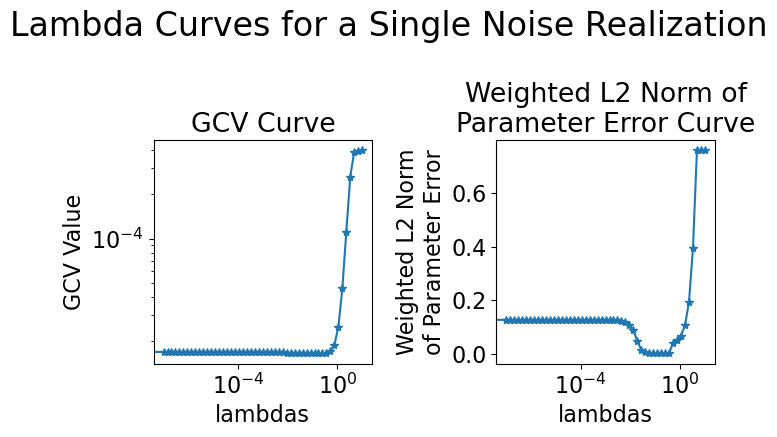

In [51]:
noise_realization = 2

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize=(7,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"Lambda Curves for a Single Noise Realization")
plt.rc('font', size = 16)
ax[0].set_title('GCV Curve')
ax[0].set_xlabel('lambdas')
ax[0].set_ylabel('GCV Value')
ax[0].loglog(lambdas, spec_GCV_curves[noise_realization,:], marker = '*')

ax[1].set_title('Weighted L2 Norm of\nParameter Error Curve')
ax[1].set_xlabel('lambdas')
ax[1].set_ylabel('Weighted L2 Norm\nof Parameter Error')
ax[1].semilogx(lambdas, spec_orc_curves[noise_realization,:], marker = '*')

plt.show()

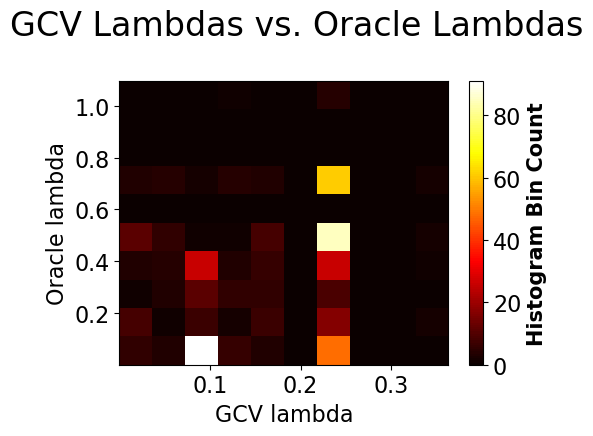

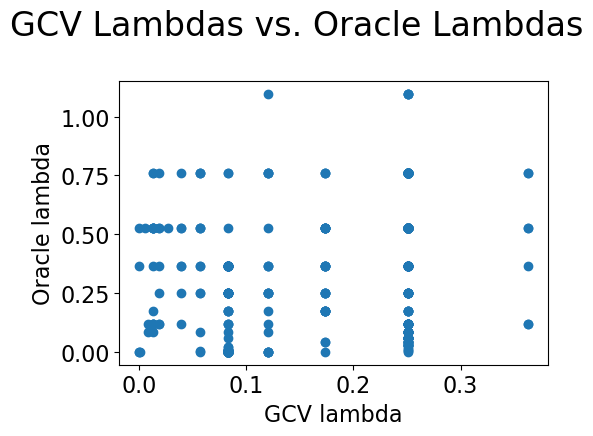

In [63]:

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"GCV Lambdas vs. Oracle Lambdas")
plt.rc('font', size = 16)
data = ax.hist2d(spec_GCV_lambdas, spec_orc_lambdas, cmap = plt.get_cmap('hot', 128))
ax.set_xlabel('GCV lambda')
ax.set_ylabel('Oracle lambda')
cbar = fig.colorbar(data[3])
cbar.set_label(label=f'Histogram Bin Count',size=15, weight='bold')

plt.show()

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"GCV Lambdas vs. Oracle Lambdas")
plt.rc('font', size = 16)
ax.scatter(spec_GCV_lambdas, spec_orc_lambdas)
ax.set_xlabel('GCV lambda')
ax.set_ylabel('Oracle lambda')


plt.show()

In [67]:
cov_result = np.cov(spec_GCV_lambdas, spec_orc_lambdas)
corr = scipy.stats.pearsonr(spec_GCV_lambdas, spec_orc_lambdas)

print(f"Pearson's Correlation Coefficient = {corr}")

Pearson's Correlation Coefficient = PearsonRResult(statistic=0.393959556629362, pvalue=5.178965822390799e-20)
